In [30]:
%matplotlib inline
import os
import glob
import argparse
import numpy as np
import pylab as plt
import rficnn as rfc
from time import time
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d


def cdf(data,nbins = 1000):
    hist, bin_edges = np.histogram(data,nbins,normed=1)
    comh = np.cumsum(hist)
    bin_centers = np.array([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(nbins)])
    comh = comh/comh.max()
    return bin_centers,comh

def root_find(x,y,x0,trs,dx=1e-2,dx_min=1e-5):
    f = interp1d(x,y, kind='linear')
    while dx > dx_min:
        x0 = x0-dx
        if (x0 <= np.nanmin(x)):
            return np.nanmin(x), y[x==np.nanmin(x)]
        if f(x0)<trs:
            x0 = x0+dx
            dx = dx/2.
    return x0,f(x0)

In [50]:
arch = '0'
time_limit = 5
learning_rate = 0.002
one_hot = 0

if one_hot:
    arch = 'arch_'+arch+'_3class'
    mode = 'one_hot'
else:
    arch = 'arch_'+arch
    mode = 'embed'

thresholds = [1e-10, 0.1]
th_labels = [0,1,2]
ws = 400

model_add = './models/multiclass_model_'+arch+'_'+mode
files_list = sorted(glob.glob('../../../../works/RFI/data/hide_sims_train/calib_1year/TEST_MP_PXX_20160102_000000.fits'))
rfc.the_print('number of files: '+str(len(files_list)))

dp = rfc.DataProvider(files=files_list,label_name='RFI',
                      ny=ws,
                      one_hot=one_hot,
                      thresholds=thresholds,
                      th_labels=th_labels,
                      a_min=0, a_max=200)

_,nx,ny,nc = dp(1)[1].shape
print(dp(1)[1].shape)

 number of files: 1 
(1, 276, 400, 1)


In [51]:
dp = rfc.DataProvider(files=files_list,label_name='RFI',
                      a_min=0, a_max=200)

data,rfi = dp(1)
print data.shape,rfi.shape

(1, 276, 14400, 1) (1, 276, 14400, 1)


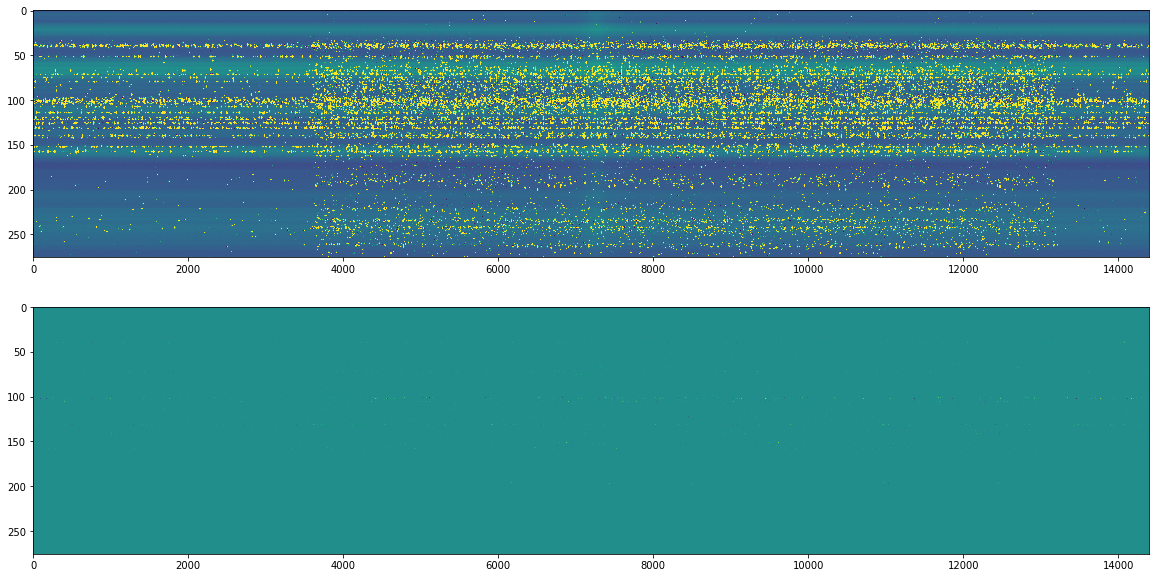

In [52]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
ax1.imshow(data[0,:,:,0],aspect='auto') 
ax2.imshow(rfi[0,:,:,0],aspect='auto') 

(0.0005, array([0.63162364]))

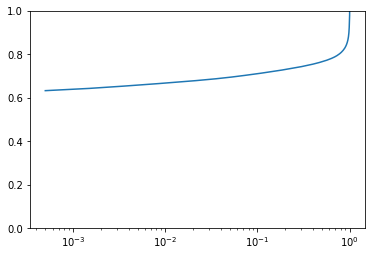

In [53]:
rfi = np.clip(rfi,1e-30,1e10)
bin_centers,comh = cdf(rfi/(rfi+data)z)
plt.plot(bin_centers,comh)
plt.ylim(0,1)
plt.xscale('log')

# x = bin_centers
# root_find(x,comh,x.max(),0.5,dx=1e-2,dx_min=1e-5)

In [11]:
conv = rfc.ConvolutionalLayers(nx=nx,ny=ny,n_channel=1,n_class=nc,
                               restore=os.path.exists(model_add),
                               model_add=model_add,
                               arch_file_name=arch)

rfc.the_print('learning rate='+str(learning_rate),bgc='blue')
conv.train(data_provider=dp,training_epochs = 10000000,n_s = 20,
           learning_rate = learning_rate, dropout=0.7, time_limit=time_limit, verbose=1)


 learning rate=0.002 


KeyboardInterrupt: 

In [10]:
test_files = sorted(glob.glob('../../../../works/RFI/data/hide_sims_train/calib_1year/TEST_MP_PXX_20160103_000000.fits'))

for fil in test_files:

    fname = fil.split('/')[-1]
    dp = rfc.DataProvider(files=[fil],label_name='RFI',
                  one_hot=one_hot,
                  thresholds=thresholds,
                  th_labels=th_labels,
                  a_min=0, a_max=200)
    data,mask = dp(1)

    pred = conv.conv_large_image(data,pad=10,lx=276,ly=400)       

    y_true = mask[0,10:-10,10:-10,:]

    if one_hot:
        pred = pred[10:-10,10:-10,:]
        y_true = np.argmax(y_true,axis=-1).astype(int).reshape(-1)
        y_score = np.argmax(pred,axis=-1).astype(int).reshape(-1)
    else:
        pred = pred[10:-10,10:-10]
#         y_true = y_true.astype(int).reshape(-1)
#         y_score = pred
#         y_score = y_score-y_score.min()
#         y_score = nc*y_score/y_score.max()-0.5
#         y_score = np.around(y_score).astype(int).reshape(-1)

#     cnf_matrix = confusion_matrix(y_true, y_score)
#     print 1.*np.trace(cnf_matrix)/np.sum(cnf_matrix)


NameError: name 'conv' is not defined

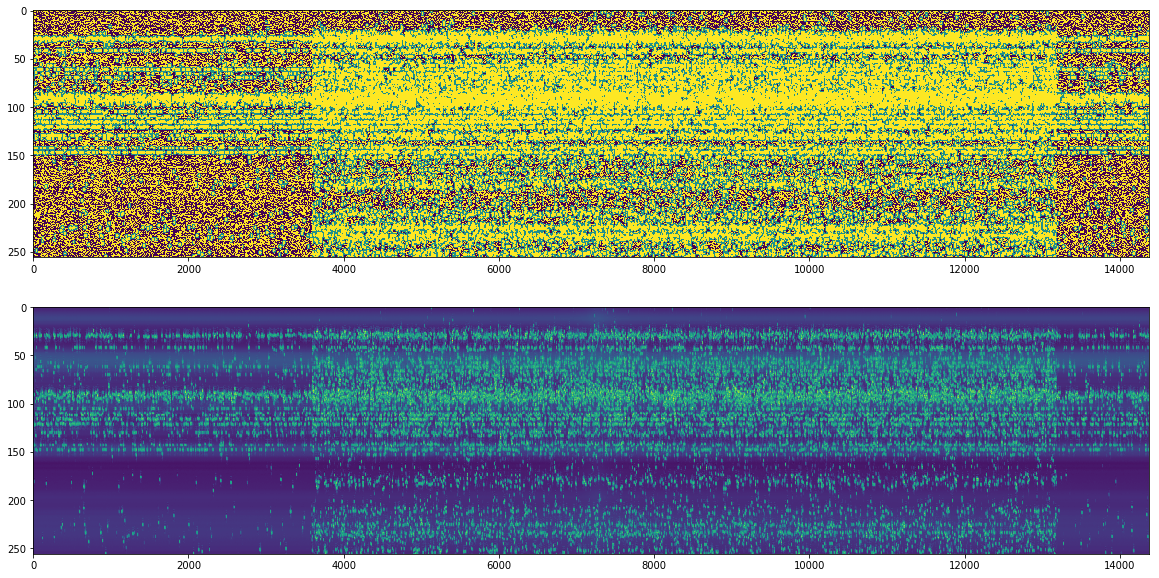

In [25]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
ax1.imshow(y_true[:,:,0],aspect='auto') 
ax2.imshow(pred,aspect='auto') 

In [9]:
bin_centers,comh = cdf(pred)
plt.plot(bin_centers,comh)

NameError: name 'pred' is not defined

In [36]:


root_find(x,comh,x.max(),0.5,dx=1e-2,dx_min=1e-5)

(0.9476933131516054, array(0.50001922))